<a id="top"></a>
<img src="face.jpg" style="float: left; margin:20px; height: 200px">
# Capstone Project: Face Orientation Classifier

_Jonah Van Arsdale_



---




### _Index_
- [Loading the data](#data)
- [CNN](#cnn)
    - [Compiler](#compiler)
    - [Summary](#summary)
    - [Running the model](#run)
    - [Scores](#scores)
    - [Scoring curves](#curves)
- [Visualisation](#vis)
    - [Single layer activation](#single)
    - [Single filter activation](#single2d)
    - [convolutional filter](#conv)
    - [Image attention](#attention)
    - [Single Image Tests](#singletests)

### Summary

#### Goals
- Pinpont and record customer visual attention
- Optimize advertisement and product placement
- Differentiate external and interal advertisements
- **Develop model to classify face orientation**

#### Metrics
- Baseline 20%
- Loss: ~0
- Accuracy: >60%
- f1 score: >60%

#### Findings
- Loss: 0.29
- Accuracy: 92%
- f1 score: 92%

#### Risks/Limitations
- Only 5 classes
- needs clear background
- needs level pitch angle

#### Future plans
- Put model on AWS
- Get more data
- Real time predictions
- Increase classes

In [1]:
import os
import shutil
import h5py
from IPython.display import display,SVG
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

import keras 
from keras import backend as K
from keras import activations
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, RMSprop
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from vis.utils import utils
from vis.visualization import visualize_activation, visualize_saliency, overlay
from vis.visualization import get_num_filters
from vis.input_modifiers import Jitter

%matplotlib inline

Using TensorFlow backend.


<a id="data"></a>
## Loading the data

Using the Colorferet Image Database with around 14,000 images

 6,608 images for the 5 classes:
- **fa**: front angle
- **hl**: half left
- **hr**: half right
- **pl**: profile left
- **pr**: profile right 

**Original folder format**



    \0001
        \0001_hl
        \0002_hl
    \0002
        \0001_hl
        \0001_hr
        
**Ideal folder format**
      
    \Train
        \hl
            \0001_hl
        \hr
            \0001_hr
    \Validation
        \hl
            \0002_hl
        \hr
            \0002_hr
            

bash code to move the image files over subfolders
 ```bash           
for /r \images\ %x in (*hl*) do copy %x \train\hl

```

In [2]:
# Globals to be used for neural networks
# sz is the size of the image, works best in square images
sz = 150
batch_size = 32
nb_train_samples = 3940
nb_val_samples = 1338
epochs = 40

In [3]:
def load_data():
    # Creates a generator which holds the path to the image files to be used in keras 

    # Creates a data augmentor which manipulates the image to simulate more data
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2)

    val_datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Initialise the generators for the train,validation and test data
    train_generator = train_datagen.flow_from_directory(
            'D:/capstone/data/train',
            target_size=(sz, sz),
            batch_size=batch_size)

    validation_generator = val_datagen.flow_from_directory(
            'D:/capstone/data/val',
            target_size=(sz, sz),
            batch_size=batch_size)

    test_generator = val_datagen.flow_from_directory(
            'D:/capstone/data/test',
            target_size=(sz, sz),
            batch_size=batch_size,
            shuffle=False)
    
    # Changes the input shapes incase some files have the channels first
    if K.image_data_format() == 'channels_first':
        input_shape = (3, sz, sz)
    else:
        input_shape = (sz, sz, 3)

    return train_generator, validation_generator, test_generator

In [4]:
train,val,test = load_data()

Found 3940 images belonging to 5 classes.
Found 1338 images belonging to 5 classes.
Found 1330 images belonging to 5 classes.


6608 Total

In [ ]:
def Class_Counter(train, val, test):
    
    # Grab the data generators and put them in a list to iterate over.
    generators = [train, val, test]
    name = ['Train','Validation','Test']
    
    # Get the names of the classes.
    keys = list(train.class_indices.keys())

    # Print out the formatting for a nice looking table.
    print('{:>10} {:>4} {:>4} {:>4} {:>4} {:>4}'.format('Count per class',
                                                        keys[0], keys[1], keys[2], keys[3], keys[4]))
    
    # Loop over the data generators and print the count of each class.
    for i,g in enumerate(generators):

        class_counter = list(np.bincount(g.classes))

        print('{0:>15}: {1:}'.format(name[i],class_counter))

In [ ]:
Class_Counter(train, val, test)

In [ ]:
def data_augmentor():
    # Generates extra data to help low data issues by manipulating the image
    datagen = ImageDataGenerator(
                shear_range=0.2,
                zoom_range=0.2)

    img = image.load_img('D:/capstone/data/train/fa/00002_930831_fa.ppm') 
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Creates 20 images which have been manipulated
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='preview'):
        i += 1
        if i > 20:
            break 

In [ ]:
# Example of a Half Right image
img_path = 'D:/capstone/data/train/hl/00002_940422_hl.ppm'
img = image.load_img(img_path, target_size=(125, 125))
print(type(img))

x = image.img_to_array(img)
print(type(x))
print(x.shape)
plt.figure(figsize=(7,7))
plt.imshow(x/255.)
plt.show()

In [ ]:
# Example of Pose Left
img_path = 'D:/capstone/data/train/pl/00002_931230_pl.ppm'
img = image.load_img(img_path, target_size=(125, 125))

x = image.img_to_array(img)
plt.figure(figsize=(7,7))
plt.imshow(x/255.)
plt.show()

[Back to top](#top)


<a id="cnn"></a>
## CNN

**Why Convolutional Neural Networks?**
- CNN knows images have patterns
- Creates small tile features to learn
- Pools values to reduce size
- Reduces to single dimension
<img src="cnn.jpg" style="float: left; margin:20px; height: 300px">

<a id="compiler"></a>
### Compiler

In [5]:
# From Keras 1.0 files.

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [6]:
def Compile_Model():
    # Creates a compiles the convolutional neural network
    model = Sequential()

    # 3 times a charm
    model.add(Conv2D(32, (3, 3), input_shape=(sz,sz,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
#     rmsprop = RMSprop(lr=0.006, rho=0.9, epsilon=None, decay=0.0)
    
    # softmax takes exponentials  of inputs and generates fraction
    
    # Stochastic gradient descent to test out
    # sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)

    # crossentropy creates an error based on the distrubution of the classes
    # rmsprop changes learning rate on parameter frequency
    # Added the f1 score to the metrics to make sure the model isnt getting type 1 and 2 errors

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['categorical_accuracy',f1_score])
    return model

In [7]:
model = Compile_Model()

<a id="summary"></a>
### Model Summary

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

<a id="run"></a>
### Running the model

In [9]:
def Run_Model(model):
    # Run the model onto a variable so I can get the history of the scores
    # Need to explicitly state the steps as it is feeding from a generator
    hist = model.fit_generator(
        train,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val,
        validation_steps=nb_val_samples // batch_size)
    return hist

In [10]:
hist = Run_Model(model)

Epoch 1/40
123/123 [==============================] - 200s 2s/step - loss: 1.2412 - categorical_accuracy: 0.4665 - f1_score: nan - val_loss: 0.6675 - val_categorical_accuracy: 0.7409 - val_f1_score: 0.7028
Epoch 2/40
123/123 [==============================] - 89s 728ms/step - loss: 0.8295 - categorical_accuracy: 0.6364 - f1_score: 0.5898 - val_loss: 0.5097 - val_categorical_accuracy: 0.7851 - val_f1_score: 0.7831
Epoch 3/40
123/123 [==============================] - 90s 730ms/step - loss: 0.6666 - categorical_accuracy: 0.7139 - f1_score: 0.6929 - val_loss: 0.4173 - val_categorical_accuracy: 0.8308 - val_f1_score: 0.8269
Epoch 4/40
123/123 [==============================] - 89s 726ms/step - loss: 0.5880 - categorical_accuracy: 0.7469 - f1_score: 0.7356 - val_loss: 0.3754 - val_categorical_accuracy: 0.8445 - val_f1_score: 0.8403
Epoch 5/40
123/123 [==============================] - 89s 725ms/step - loss: 0.5397 - categorical_accuracy: 0.7650 - f1_score: 0.7595 - val_loss: 0.3711 - val_ca

Epoch 40/40
123/123 [==============================] - 89s 727ms/step - loss: 0.2863 - categorical_accuracy: 0.8814 - f1_score: 0.8834 - val_loss: 0.1983 - val_categorical_accuracy: 0.9223 - val_f1_score: 0.9219


<a id="scores"></a>
### Scores

In [11]:
# Save/Load the model 

model.save('model_40.h5')
# model.save('modelsgd.h5')

In [ ]:
model = keras.models.load_model('model.h5', custom_objects={'f1_score': f1_score})
# model = keras.models.load_model('modelsgd.h5', custom_objects={'f1_score': f1_score})

In [12]:
# Evaluate the model on the test data
score_raw = model.evaluate_generator(test)
score = list(np.around(np.array(score_raw),2))
print('Loss: {} \nAccuracy: {} \nf1 score: {}'.format(score[0],score[1],score[2]))

Loss: 0.24 
Accuracy: 0.92 
f1 score: 0.92


In [13]:
# Generate predictions and map it to the class names
predictions = model.predict_generator(test) 
predictions = np.argmax(predictions, axis=-1)

label_map = (train.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]
true = [label_map[k] for k in test.classes]

print(classification_report(true, predictions))

             precision    recall  f1-score   support

         fa       0.97      0.99      0.98       261
         hl       0.88      0.91      0.90       258
         hr       0.89      0.90      0.89       270
         pl       0.93      0.90      0.91       268
         pr       0.91      0.88      0.89       273

avg / total       0.92      0.92      0.91      1330



In [14]:
print(confusion_matrix(true, predictions))

[[259   2   0   0   0]
 [  3 236   0  19   0]
 [  4   0 242   0  24]
 [  0  27   1 240   0]
 [  0   3  30   0 240]]


<a id="curves"></a>
### Scoring curves


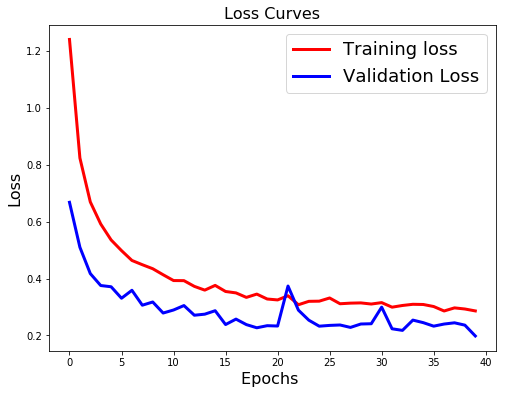

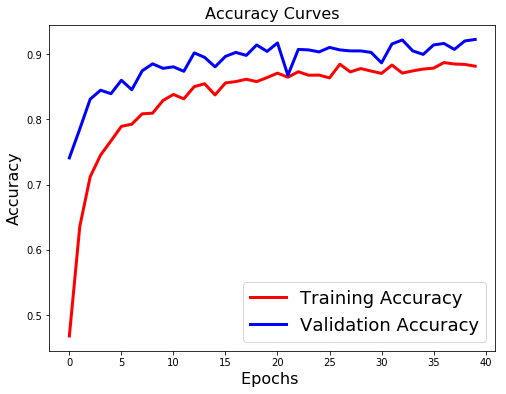

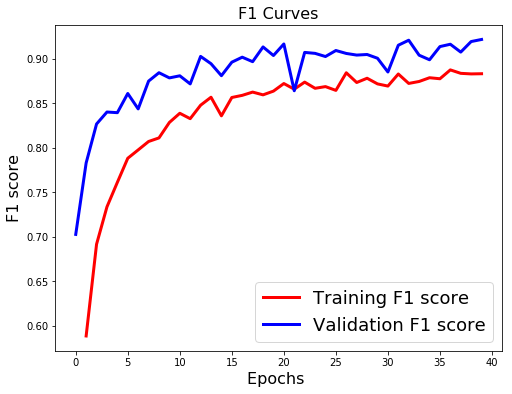

In [15]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(hist.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# f1 Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['f1_score'],'r',linewidth=3.0)
plt.plot(hist.history['val_f1_score'],'b',linewidth=3.0)
plt.legend(['Training F1 score', 'Validation F1 score'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1 score',fontsize=16)
plt.title('F1 Curves',fontsize=16)

plt.show()

[Back to top](#top)

<a id="vis"></a>
## Layer Visualisation

In [16]:
# Change the final layer to a linear activation
# The packages code doesnt work and my work around sometimes also doesnt work
layer_idx = -1
model.layers[layer_idx].activation = activations.linear
model.save('model_test.h5')
model.layers[layer_idx].activation = activations.softmax

In [17]:
model_lin = keras.models.load_model('model_test.h5', custom_objects={'f1_score': f1_score})

<a id="single"></a>
### Single layer activations

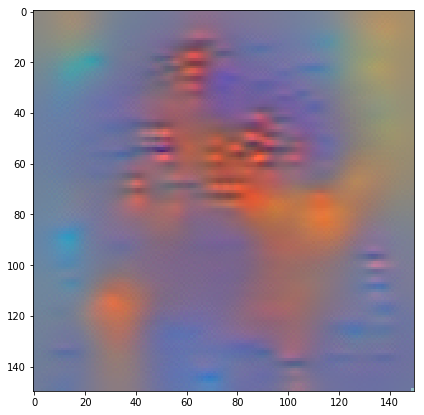

In [21]:
# Final layer with all categorical filters and some jitter to smooth
plt.figure(figsize=(7,7))
img = visualize_activation(model_lin, layer_idx)
plt.imshow(img)
plt.show()

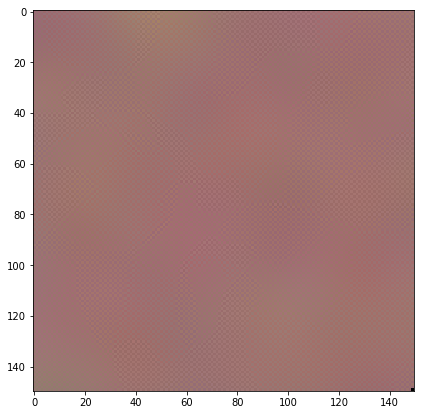

In [29]:
# Single convolutional filter
# Doesnt show accurately the results

plt.figure(figsize=(7,7))
layer = utils.find_layer_idx(model_lin, 'conv2d_1')

img = visualize_activation(model_lin, layer,filter_indices= 5)
plt.imshow(img)
plt.show()

<a id="single2d"></a>
### Single filter activation

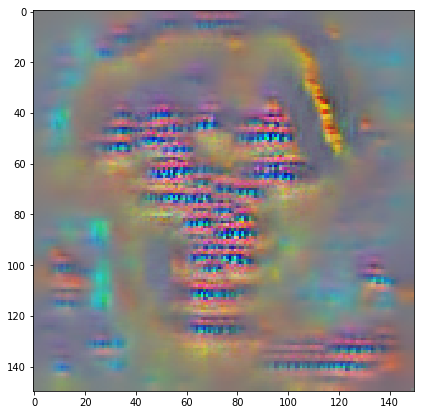

In [33]:
# Filter activation for the 'fa' front angle class
filter_idx = 0
img = visualize_activation(model_lin, layer_idx, filter_indices=filter_idx)
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.show()

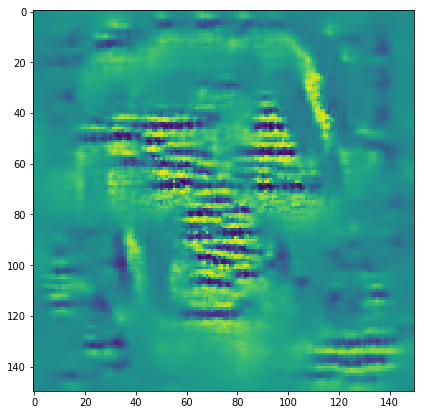

In [31]:
# Same image but without the rgb channel
filter_idx = 0
img = visualize_activation(model_lin, layer_idx, filter_indices=filter_idx)
plt.figure(figsize=(7,7))
plt.imshow(img[..., 0])
plt.show()

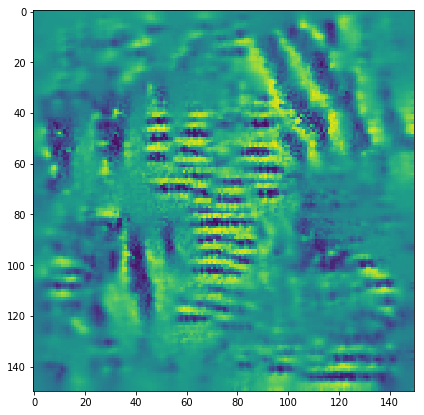

In [32]:
# Constraining the inputs
img = visualize_activation(model_lin, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.figure(figsize=(7,7))
plt.imshow(img[..., 0])
plt.show()

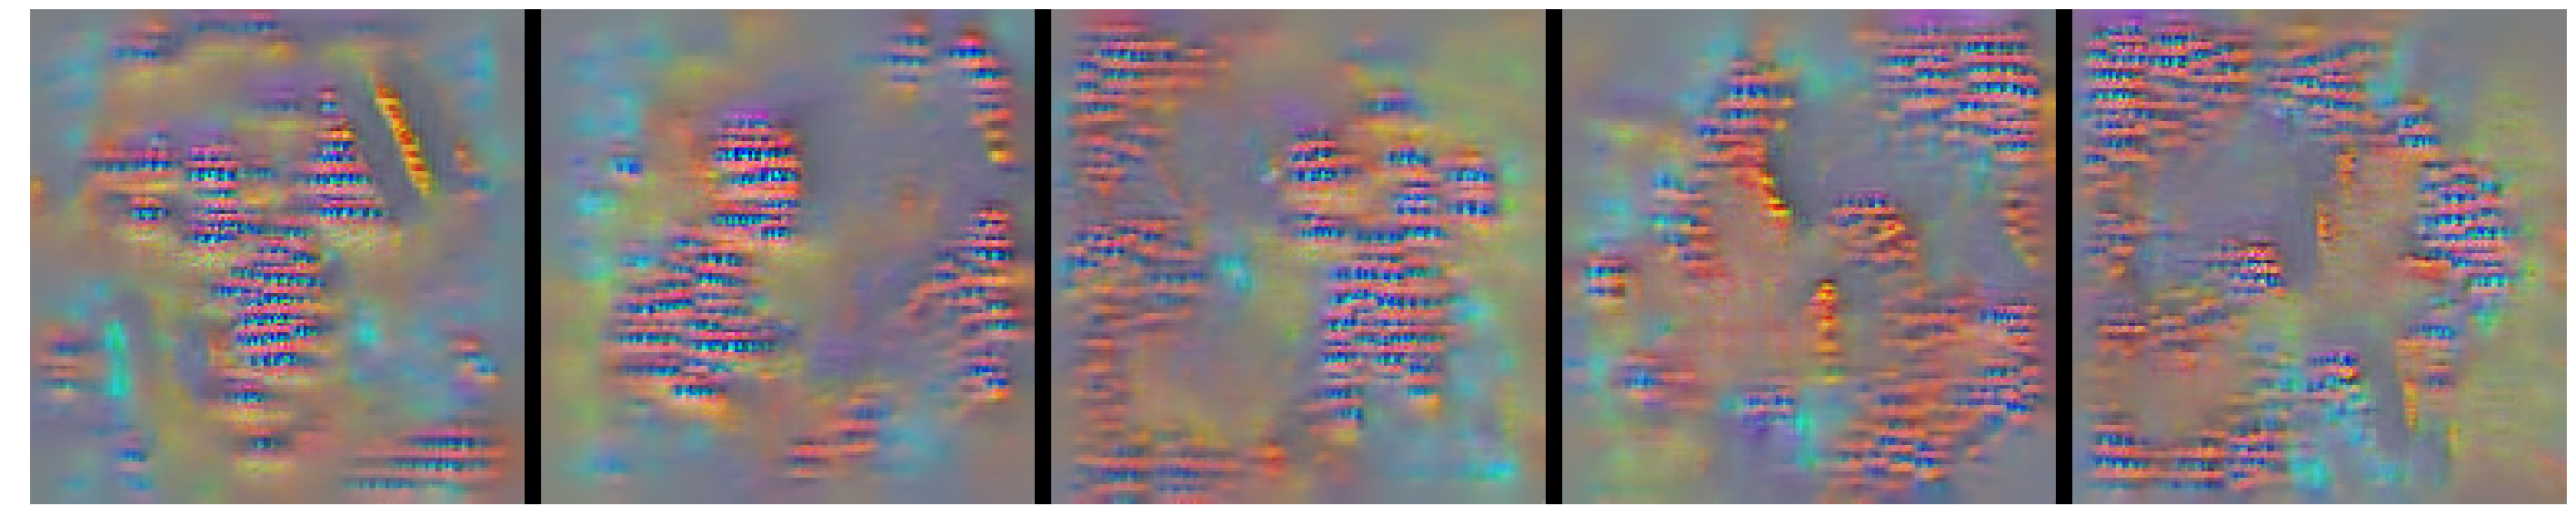

In [34]:
# Filter for each of the classes
vis_images = []
for output_idx in np.arange(5):
    img = visualize_activation(model_lin, layer_idx, filter_indices=output_idx)
    vis_images.append(img)

# Generate stitched images with 5 cols (so it will have 3 rows).
plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images, cols=5)
plt.axis('off')
plt.imshow(stitched)
plt.show()

In [35]:
list(train.class_indices)

['fa', 'hl', 'hr', 'pl', 'pr']

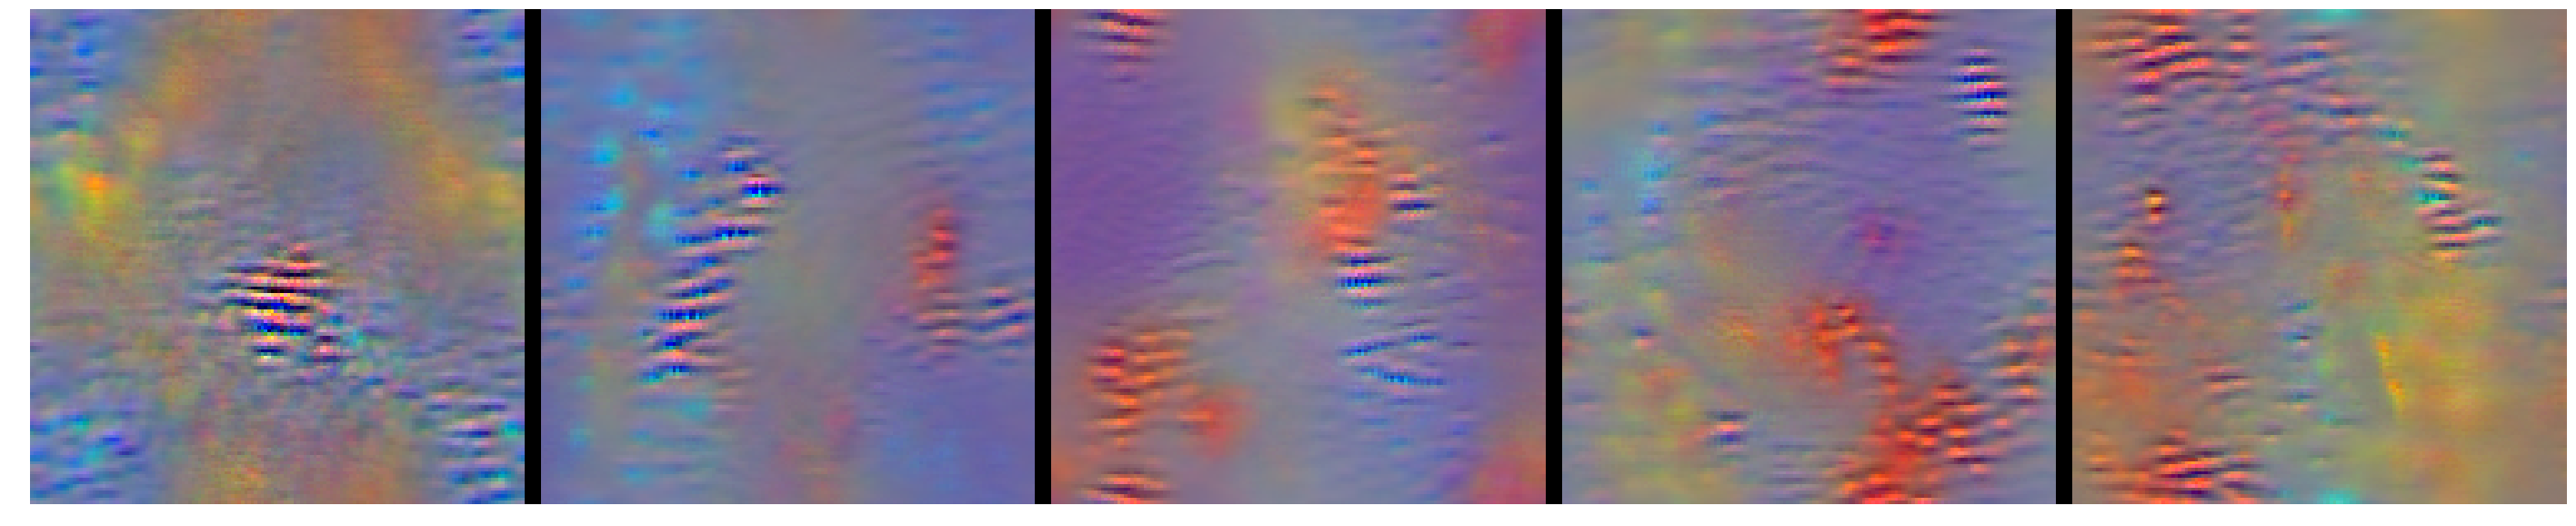

In [36]:
vis_images = []
image_modifiers = [Jitter(16)]
for idx in range(5):    
    img = visualize_activation(model_lin, layer_idx, filter_indices=idx, max_iter=500, input_modifiers=image_modifiers)
    
    vis_images.append(img)

# Generate stitched images with 5 cols (so it will have 3 rows).
plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images, cols=5)
plt.axis('off')
plt.imshow(stitched)
plt.show()

<a id="conv"></a>
### Convolutional filter visualisation

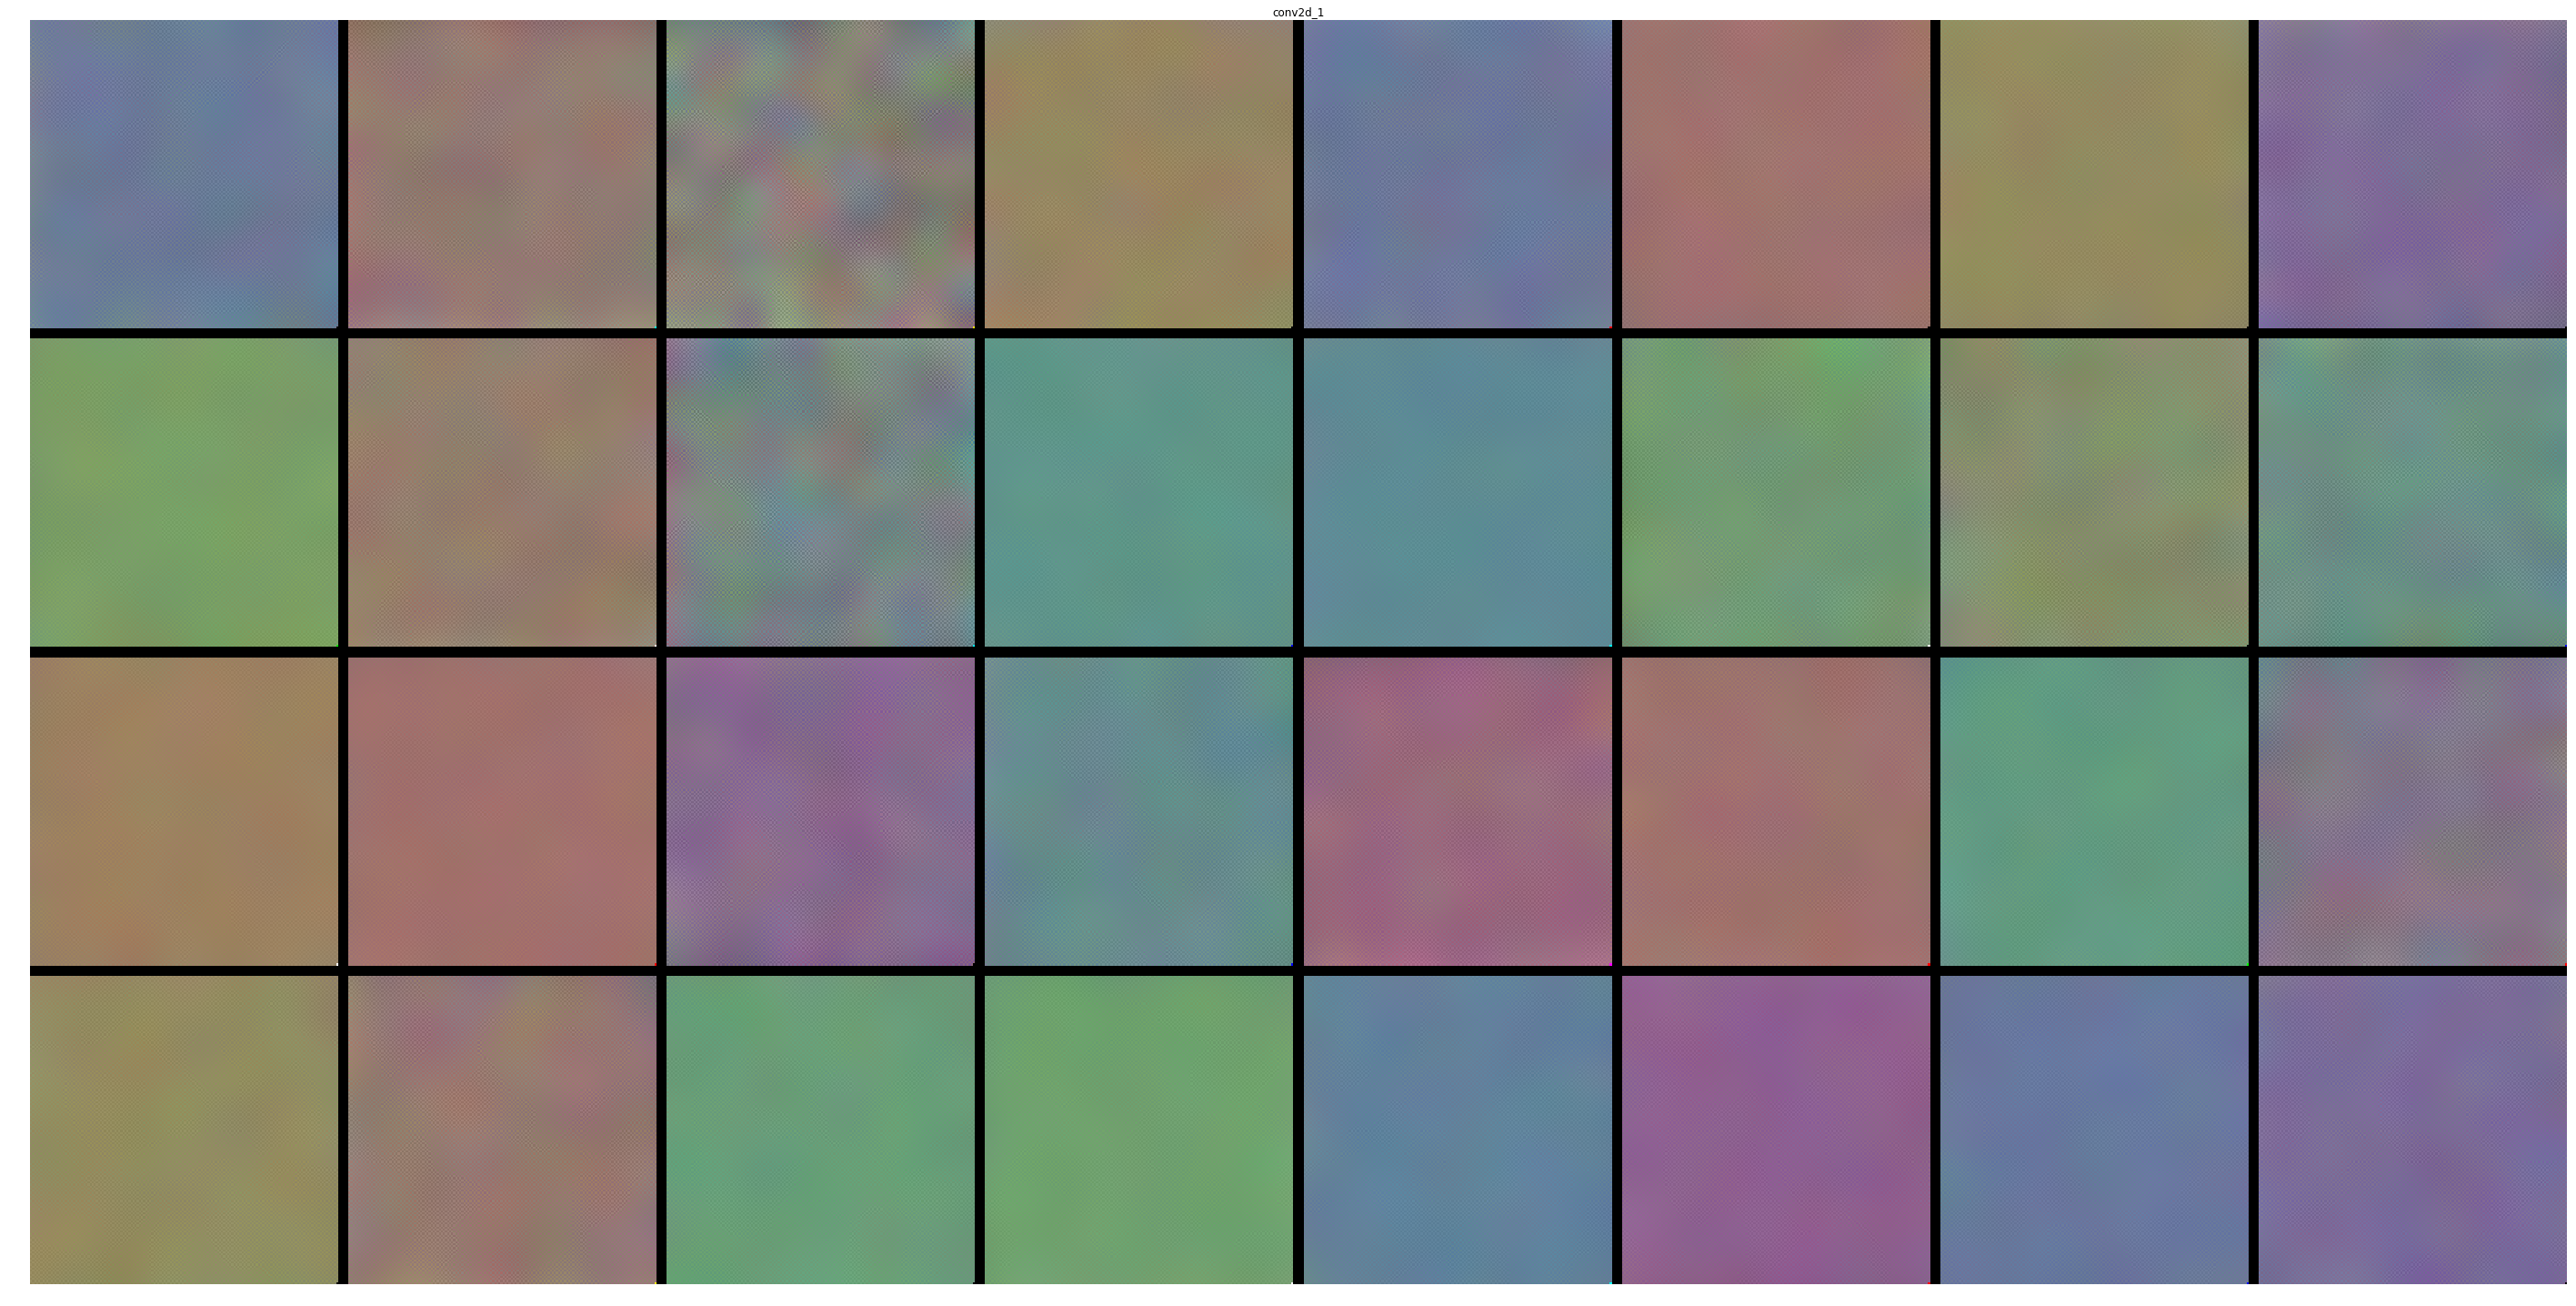

In [37]:
# The name of the layer we want to visualize
layer_name = 'conv2d_1'
layer_idx = utils.find_layer_idx(model_lin, layer_name)

# Visualize all filters in this layer
filters = np.arange(get_num_filters(model_lin.layers[layer_idx]))

# Generate input image for each filter
vis_images = []
for idx in filters:
    img = visualize_activation(model_lin, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image  
    vis_images.append(img)

# Generate stitched image palette with 8 cols
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

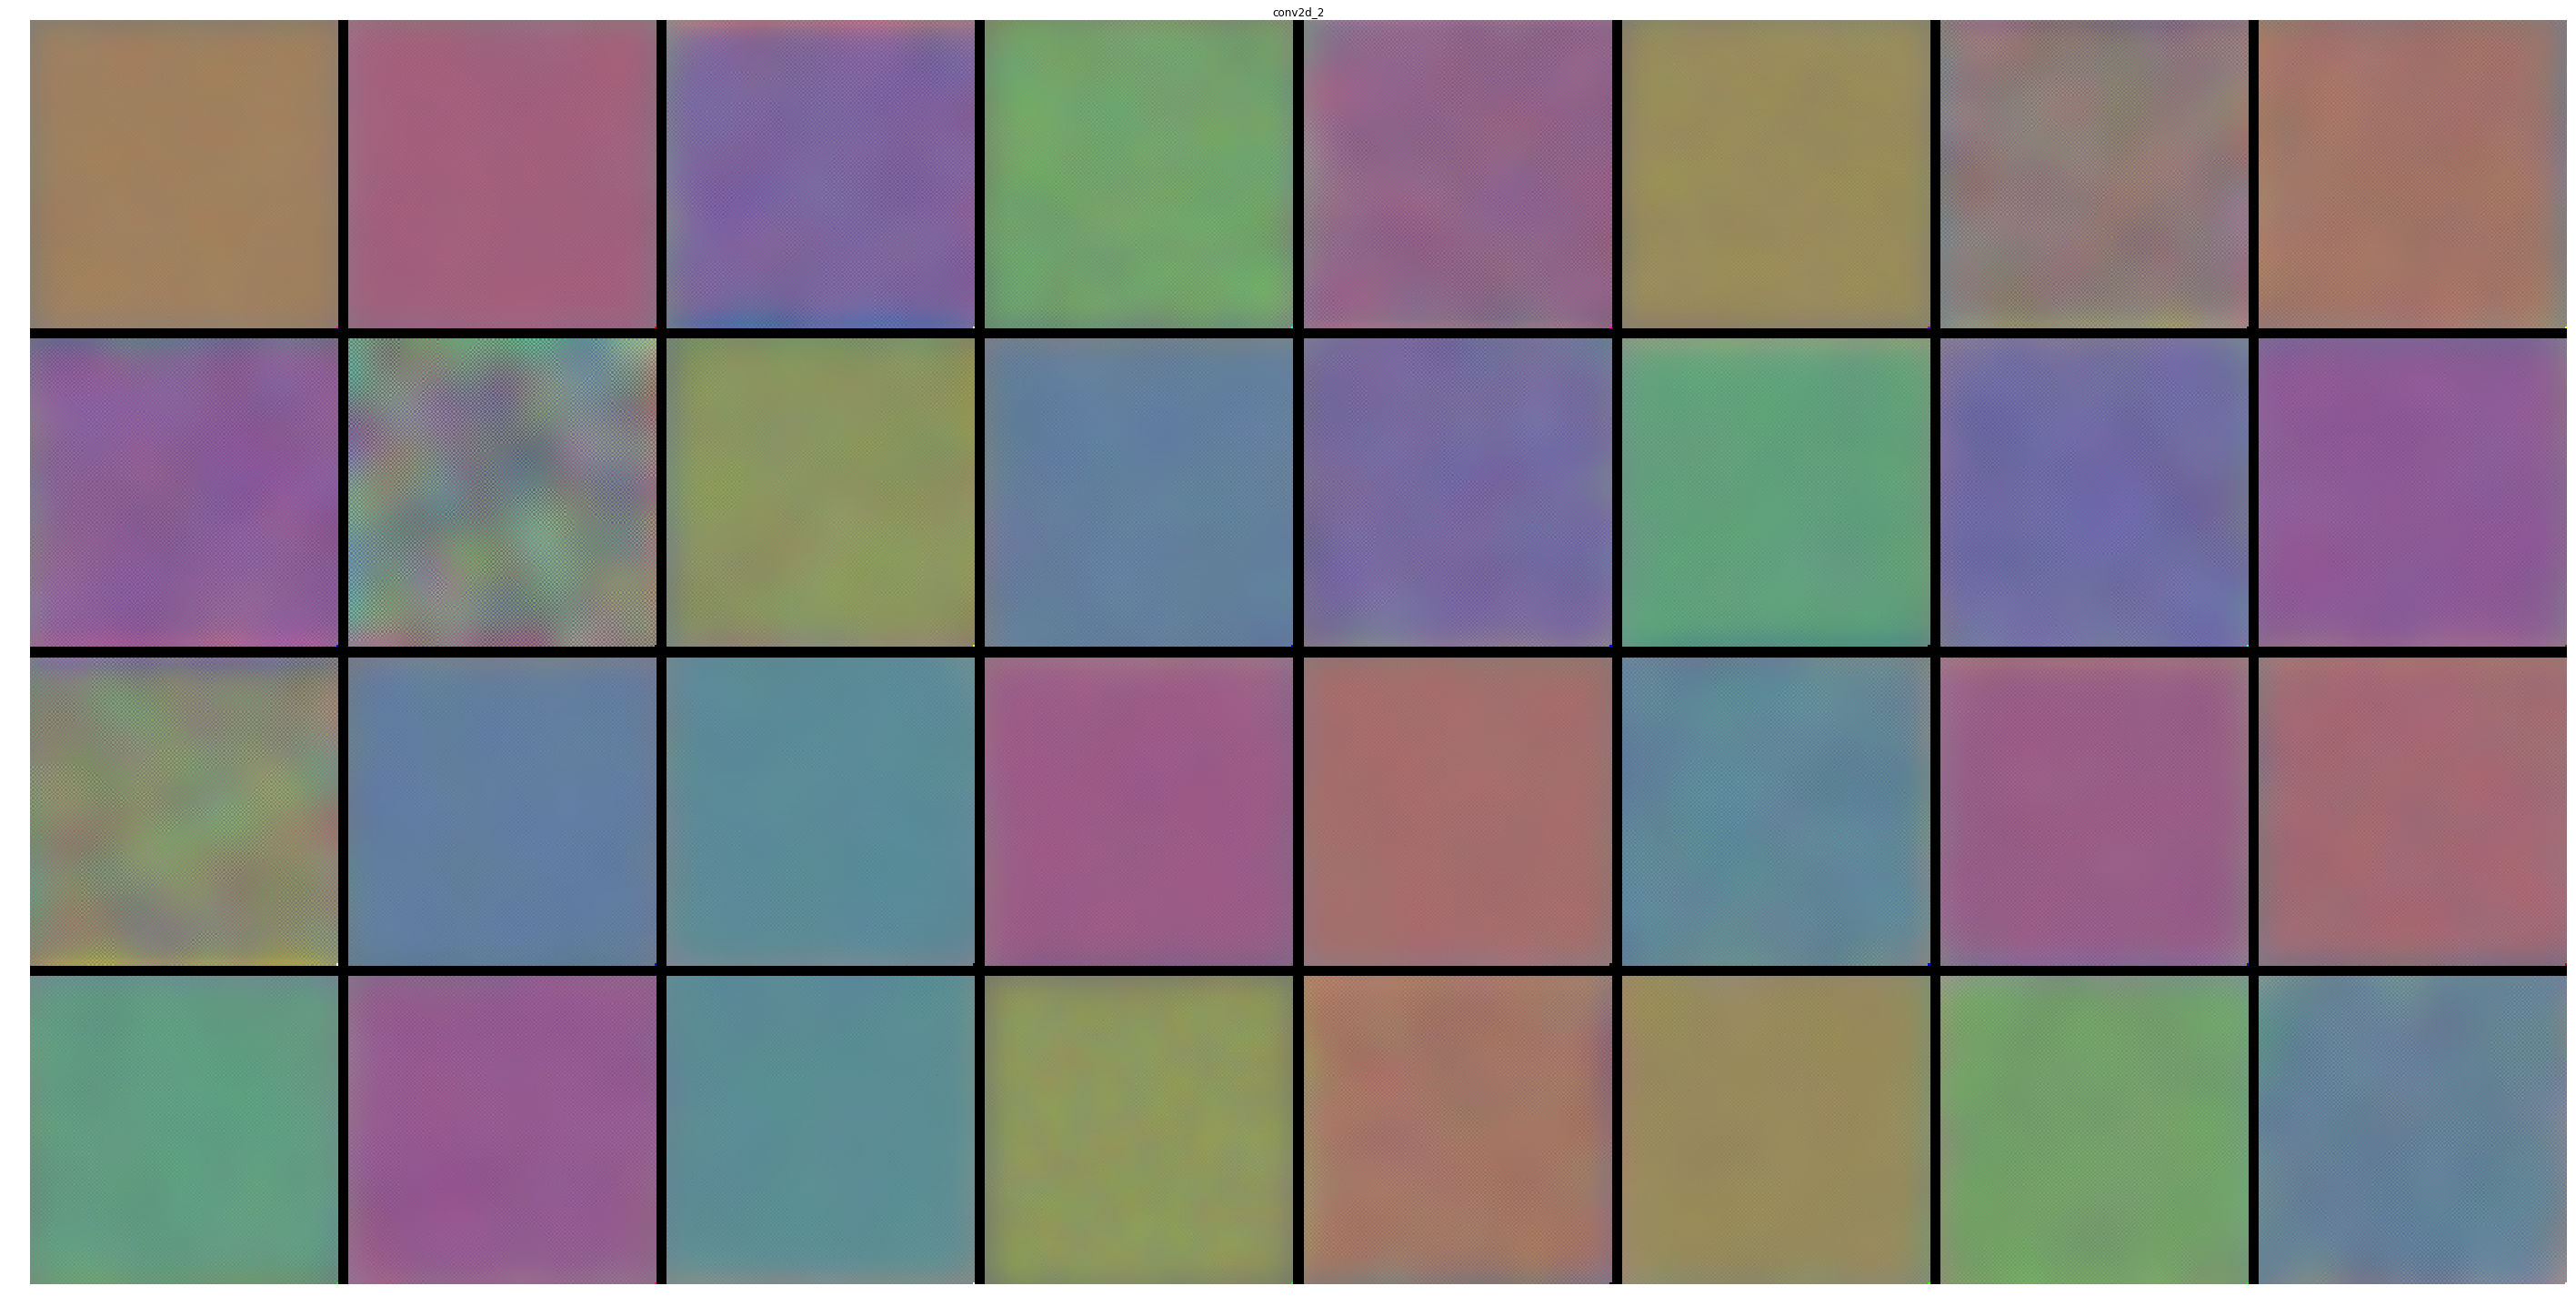

In [114]:
layer_name = 'conv2d_2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image   
    vis_images.append(img)

# Generate stitched image palette with 8 cols
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

In [ ]:
# The name of the layer we want to visualize

layer_name = 'conv2d_3'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image   
    vis_images.append(img)

# Generate stitched image palette with 8 cols
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

<a id="attention"></a>
### Image Attention Visualisation

C:\Users\ASUS-PC\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


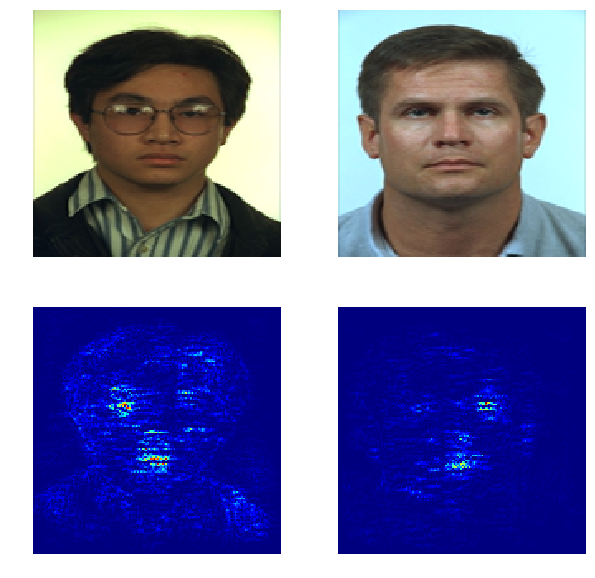

In [112]:
# front angle test
img1 = utils.load_img('D:/capstone/data/test/fa/00204_940128_fa_a.ppm', target_size=(sz, sz))
img2 = utils.load_img('D:/capstone/data/test/fa/00960_960627_fa.ppm', target_size=(sz, sz))

filter_idx = -1
f, ax = plt.subplots(2, 2,figsize=(10,10))
for i, img in enumerate([img1, img2]):    
    grads = visualize_saliency(model_lin, filter_idx, filter_indices=0, seed_input=img,grad_modifier='relu')
    
    # visualize grads as heatmap
    ax[1,i].imshow(grads, cmap='jet')
    ax[1,i].axis('off')
    ax[0,i].imshow(img)
    ax[0,i].axis('off')

C:\Users\ASUS-PC\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


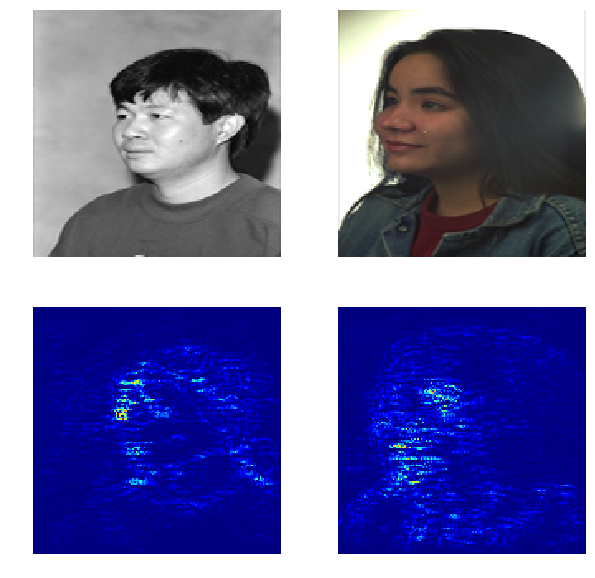

In [109]:
# Testing half left images
img1 = utils.load_img('D:/capstone/data/test/hl/00029_930831_hl.ppm', target_size=(sz,sz))
img2 = utils.load_img('D:/capstone/data/test/hl/00454_940422_hl.ppm', target_size=(sz,sz))

f, ax = plt.subplots(2, 2,figsize=(10,10))
for i, img in enumerate([img1, img2]):    
    grads = visualize_saliency(model_lin, filter_idx, filter_indices=1, seed_input=img, grad_modifier='relu')
    
    # visualize grads as heatmap
    ax[1,i].imshow(grads, cmap='jet')
    ax[1,i].axis('off')
    ax[0,i].imshow(img)
    ax[0,i].axis('off')

<a id="singletests"></a>
### Single Image Tests

In [52]:
# convert the predicted class index to the name
def reclass(pred):
    if pred == [0]:
        predict = 'Front Angle'
    elif pred == [1]:
        predict = 'Half Left'
    elif pred == [2]:
        predict = 'Half Right'
    elif pred == [3]:
        predict = 'Profile Left'
    else:
        predict = 'Profile Right'
    return predict

C:\Users\ASUS-PC\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


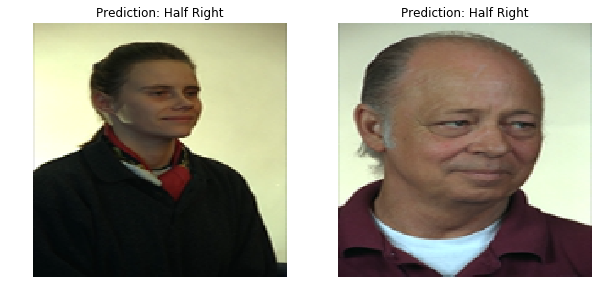

In [55]:
# Test a couple images individually
img1 = utils.load_img('D:/capstone/data/test/hr/00040_931230_hr.ppm', target_size=(sz,sz))
img2 = utils.load_img('D:/capstone/data/test/hr/00471_940519_hr.ppm', target_size=(sz,sz))

img_pred = np.expand_dims(img1, axis=0)
pred1 = reclass(model.predict_classes(img_pred))

img_pred2 = np.expand_dims(img2, axis=0)
pred2 = reclass(model.predict_classes(img_pred2))

f, ax = plt.subplots(1, 2,figsize=(10,10))

ax[0].set_title("Prediction: {}".format(pred1))
ax[0].imshow(img1)
ax[0].axis('off')

ax[1].set_title("Prediction: {}".format(pred2))
ax[1].imshow(img2)
ax[1].axis('off')

plt.show()

[Back to top](#top)